# Data Visualization
This notebook contains visualizations for data samples of Muscles in Action (MIA).

### MIA Samples
This notebook visualizes MIA data samples together with predictions of a network which was pretrained on MinT and then partially fine-tuned on the first and last transformer block on MIA.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import os
from os.path import join as opj
import sys
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Simple fix for smplx numpy compatibility in recent numpy versions.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_
np.complex = np.complex_
np.object = np.object_
np.unicode = np.unicode_
np.str = np.str_

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec

import seaborn as sns

from IPython.display import HTML, display, Video

from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
from scipy.interpolate import interp1d

from smplx.body_models import SMPL, SMPLH

os.environ['PYOPENGL_PLATFORM'] = 'egl'

from musint.benchmarks.muscle_sets import MIA_MUSCLES
from musint.benchmarks.muscle_sets import MUSCLE_SUBSETS

import mia_utils as miau
import amass_utils as amau
from plotting_utils import visualize_pose, plot_emg_data

In [2]:
# Set global plot parameters for consistent styling
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "font.sans-serif": ["Helvetica"],
        "figure.figsize": (6, 4.8),  # Figure size
        "font.size": 12,  # Global font size
        "axes.titlesize": 12,  # Title font size
        "axes.labelsize": 12,  # Axes labels font size
        "xtick.labelsize": 12,  # X-tick labels font size
        "ytick.labelsize": 12,  # Y-tick labels font size
        "legend.fontsize": 12,  # Legend font size
        "figure.titlesize": 12,  # Figure title font size
    }
)

In [3]:
data_dir_mia = "notebook_resources/mia_root"

In [4]:
mia_metadata = miau.index_mia_dataset(data_dir_mia)
mia_metadata["id"] = mia_metadata["path"].apply(lambda p: "/".join(p.split(os.path.sep)[-4:]))
mia_metadata.head()

24663it [00:49, 500.47it/s]

notebook_resources/mia_root/train/Subject3/HighKick/848/emgvalues.npy
24340


,path,split,subject,activity,repetition,id
0,notebook_resources/mia_root/train/Subject3/Hig...,train,Subject3,HighKick,848,train/Subject3/HighKick/848
1,notebook_resources/mia_root/train/Subject3/Hig...,train,Subject3,HighKick,886,train/Subject3/HighKick/886
2,notebook_resources/mia_root/train/Subject3/Hig...,train,Subject3,HighKick,836,train/Subject3/HighKick/836
3,notebook_resources/mia_root/train/Subject3/Hig...,train,Subject3,HighKick,878,train/Subject3/HighKick/878
4,notebook_resources/mia_root/train/Subject3/Hig...,train,Subject3,HighKick,874,train/Subject3/HighKick/874


In [5]:
mia_emg_data = miau.load_emg_data(list(map(lambda p: opj(p, "emgvalues.npy"), mia_metadata["path"])))
print(f"MIA data shape: {mia_emg_data.shape}")

100%|██████████| 24340/24340 [00:09<00:00, 2450.76it/s]

MIA data shape: torch.Size([24340, 30, 8])


<Axes: >

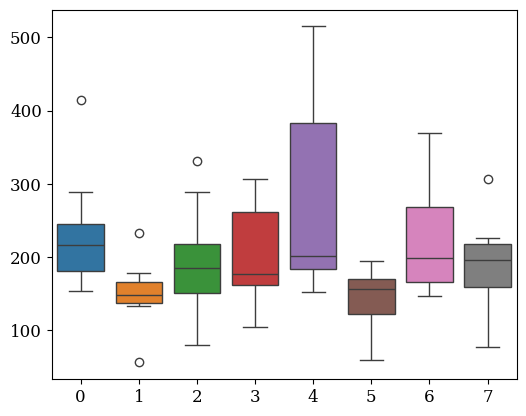

In [6]:
# MIA does not label its data with muscle names (the original MIA dataset implementation contains such an ordering but it is not used and does not correspond to the actual data).
# We recreate Figure 1 from the PDF in the supplementary here
# https://openaccess.thecvf.com/content/ICCV2023/supplemental/Chiquier_Muscles_in_Action_ICCV_2023_supplemental.zip
# to verify the order of the muscles in the dataset.
# l_quad, l_ham, l_lat, l_bicep, r_quad, r_ham, r_lat, r_bicep
# There is a slight shift in values, presumably by the selection of data (train, val, train+val) or preprocessing,
# but it is obvious the the graphs align and the column order follows the x ticks in figure 1 of the MIA supp.


def max_emg_subj(mia_emg_data, mia_metadata, subject):
    emg_dat = mia_emg_data[mia_metadata["subject"] == subject]
    max_emg = torch.max(emg_dat.reshape((-1, 8)), axis=0)
    return max_emg


per_subject_max = torch.stack([max_emg_subj(mia_emg_data, mia_metadata, f"Subject{i}")[0] for i in range(10)], dim=0)

sns.boxplot(data=per_subject_max)

In [7]:
# Compute the 99th percentile of the data along the first dimension, scaling without outliers.
pct99_norm = np.percentile(mia_emg_data.reshape((-1, 8)), 99, axis=0)

# Calulcate and save normalization statistics for the dataset.
save_stats = False

# Concatenate all the arrays from the data list into a single array for processing.
Mean = mia_emg_data.mean(
    axis=0
)  # Compute the mean of the concatenated data along the first dimension (across all samples).
Std = mia_emg_data.std(axis=0)  # Compute the standard deviation of the concatenated data along the first dimension.

Max = mia_emg_data.max(axis=0)  # Compute the maximum of the concatenated data along the first dimension.

print("Mean:", Mean)
print("Max:", Max)

if save_stats:
    save_dir_mia = "notebook_resources/mia_root"

    np.save(os.path.join(save_dir_mia, "Mean.npy"), Mean)
    np.save(os.path.join(save_dir_mia, "Std.npy"), Std)

    np.save(os.path.join(save_dir_mia, "99pct.npy"), np.percentile(mia_emg_data, 99, axis=0))

Mean: tensor([[22.3357, 18.7647, 18.6260, 19.9454, 24.1179, 19.4371, 18.6869, 18.0062],
        [22.3155, 18.7217, 18.5737, 19.9184, 24.1267, 19.4776, 18.6766, 18.0028],
        [22.4449, 18.7215, 18.5753, 19.9462, 24.2376, 19.5561, 18.6675, 18.0374],
        [22.4565, 18.8139, 18.6074, 19.9394, 24.3497, 19.6318, 18.7369, 18.0636],
        [22.4653, 18.8364, 18.6328, 19.9627, 24.3091, 19.6392, 18.7796, 18.0295],
        [22.5401, 18.8652, 18.6963, 19.9305, 24.3604, 19.6241, 18.7732, 17.9745],
        [22.5247, 18.8470, 18.6651, 19.8743, 24.4682, 19.6185, 18.7403, 17.9765],
        [22.5700, 18.8815, 18.6826, 19.9147, 24.5657, 19.6288, 18.7122, 17.9936],
        [22.5106, 18.8653, 18.6747, 19.9397, 24.6551, 19.6251, 18.7451, 18.0338],
        [22.4350, 18.8552, 18.6601, 19.9721, 24.6228, 19.5734, 18.7324, 18.0640],
        [22.4357, 18.7968, 18.6362, 19.9149, 24.6122, 19.5279, 18.6984, 18.0826],
        [22.3066, 18.7261, 18.5823, 19.7620, 24.4969, 19.5239, 18.6632, 18.0313],
        [2

In [8]:
mia_emg_dict = {mia_metadata.iloc[i]["id"]: mia_emg_data[i] for i in range(len(mia_metadata))}
next(iter(mia_emg_dict.items()))

('train/Subject3/HighKick/848',
 tensor([[60., 15., 17., 17., 31., 38.,  4., 10.],
         [57.,  9., 16., 16., 30., 31.,  3., 10.],
         [52.,  9., 13., 16., 30., 24.,  3., 10.],
         [45.,  8., 12., 14., 23., 19.,  3., 11.],
         [34.,  7., 12., 14., 23., 14.,  3., 10.],
         [26.,  6., 11., 15., 21., 12.,  3., 10.],
         [19., 10., 11., 14., 21.,  9.,  3., 10.],
         [16., 10.,  9., 13., 18.,  8.,  3., 10.],
         [14.,  9.,  8., 13., 18.,  8.,  3.,  9.],
         [14.,  8.,  6., 13., 10.,  7.,  5., 10.],
         [17., 20.,  7., 13.,  9.,  7.,  5.,  9.],
         [24., 20.,  7., 13.,  9., 20.,  5.,  9.],
         [34., 49.,  6., 13., 13., 21.,  4.,  9.],
         [45., 62.,  5., 12., 76., 29.,  5., 11.],
         [55., 62.,  5., 13., 76., 23.,  5., 10.],
         [68., 46.,  6., 13., 47., 17.,  5., 10.],
         [61., 42.,  6., 13., 47., 13.,  4., 11.],
         [61., 33.,  7., 14., 40., 10.,  4., 11.],
         [55., 25.,  7., 13., 29.,  9.,  4., 10.],

In [9]:
mia_metadata["activity"].unique()

array(['HighKick', 'HookPunch', 'LegCross', 'Squat', 'SlowSkater',
       'ElbowPunch', 'KneeKick', 'Shuffle', 'JumpingJack', 'SideLunges',
       'Running', 'FrontPunch', 'LegBack', 'FrontKick', 'RonddeJambe'],
      dtype=object)

**Please download the SMPL-H model to the respective location.**
- https://mano.is.tue.mpg.de/download.php
- https://github.com/vchoutas/smplx/blob/main/tools/README.md

In [10]:
smpl_h_path = "./body_models/smpl/SMPLH_NEUTRAL_AMASS_MERGED.pkl"
# Each VIBE sample in MIA has 30 frames at 10 fps. We convert to 20 fps by interpolating intermediate frames
# Since we only interpolate between two frames we end up with 59 frames as result.
bm = SMPLH(model_path=smpl_h_path, num_betas=10, use_pca=False, batch_size=59).cuda()

In [11]:
preds_root = "notebook_resources/mia_predictions"

mia_preds = pd.read_csv(opj(preds_root, "metadata.csv"))
mia_preds.set_index("name", inplace=True)
mia_preds["gt_name"] = mia_preds["gt_name"].apply(lambda x: x.replace("__I__", "/"))
mia_preds["pred_name"] = mia_preds["pred_name"].apply(lambda x: x.replace("__I__", "/"))
mia_preds.head()

,gt_name,pred_name,time_start
name,,,
val/Subject5/JumpingJack/81,val/Subject5/JumpingJack/81_0_gt.npy,val/Subject5/JumpingJack/81_0_pred.npy,0.0
val/Subject5/JumpingJack/81,val/Subject5/JumpingJack/81_1_gt.npy,val/Subject5/JumpingJack/81_1_pred.npy,1.4
val/Subject5/JumpingJack/98,val/Subject5/JumpingJack/98_2_gt.npy,val/Subject5/JumpingJack/98_2_pred.npy,0.0
val/Subject5/JumpingJack/98,val/Subject5/JumpingJack/98_3_gt.npy,val/Subject5/JumpingJack/98_3_pred.npy,1.4
val/Subject5/JumpingJack/92,val/Subject5/JumpingJack/92_4_gt.npy,val/Subject5/JumpingJack/92_4_pred.npy,0.0


In [32]:
rans = 42
np.random.seed(rans)
torch.manual_seed(rans)

reps = ["50", "3", "171", "57", "544", "20", "359"]
activities = ["Running", "JumpingJack", "Shuffle"]

random_sample = mia_metadata[
    (mia_metadata["split"] == "val")
    & (mia_metadata["activity"].isin(activities))
    & (mia_metadata["repetition"].isin(reps))
]

for i in tqdm(range(min(100, len(random_sample)))):
    # Setting up the visualization. Selecting a random sample.

    mia_sample = random_sample.iloc[i]

    if mia_sample["id"] not in mia_preds.index:
        print(f"Did not find emg data for {mia_sample['id']}")
        continue

    print(mia_sample["id"])

    body = miau.mia_to_smpl_body(mia_sample["path"], bm, interp=True)

    vertices = body.vertices.detach().cpu().numpy()

    gts, preds, start, end = miau.load_and_concat_mia_dat(mia_sample["id"], mia_preds, preds_root, pad=59)

    # gts = mia_emg_dict[mia_sample["id"]]
    # gts /= pct99_norm
    # Repeat each frame twice
    # gts = gts[:28]
    # gts = np.repeat(gts, 2, axis=0)
    # gts = gts[np.linspace(0, len(gts) - 1, len(vertices), dtype=int)]
    MINT_MIA_MUS = [1, 5, 0, 4]

    assert len(gts) == len(vertices)
    num_frames = min(len(vertices), len(gts), len(preds))

    gts = gts[start:num_frames, MINT_MIA_MUS] * 1.5

    preds = preds[start:num_frames, MINT_MIA_MUS] * 1.5

    vertices = vertices[start:num_frames]

    names = ["Quad. Fem. (L)", "Hamstring (L)", "Quad. Fem. (R)", "Hamstring (R)"]

    fig = plt.figure(figsize=(8, 12))

    gs = GridSpec(2, 1, height_ratios=[5, 2])

    ax = fig.add_subplot(gs[0], projection="3d")

    lines = plot_emg_data(gts, preds, names, fig=fig, gridspec=gs, ylim=None, show_pred=False)

    def update(frame):
        ax.clear()
        visualize_pose(vertices[frame], frame, ax, title=mia_sample["id"], elev=1, azim=195)

        for line in lines:
            line.set_xdata(frame)

        return [ax, lines]

    plt.tight_layout()

    ani = FuncAnimation(fig, update, frames=len(vertices), interval=50)  # 20 fps = 50ms interval

    path_id = mia_sample["id"].replace("/", "__I__")

    ani.save(f"notebook_output/mia/{path_id}.mp4", writer="ffmpeg", fps=20)
    display(Video(f"notebook_output/mia/{path_id}.mp4", embed=False))

    plt.close(fig)  # Prevents the static plot from showing

  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject3/Running/3


  7%|▋         | 1/15 [00:09<02:12,  9.50s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject9/Running/50


 13%|█▎        | 2/15 [00:19<02:05,  9.63s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject9/Running/57


 20%|██        | 3/15 [00:28<01:55,  9.59s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


Did not find emg data for val/Subject0/JumpingJack/359
val/Subject6/JumpingJack/50


 33%|███▎      | 5/15 [00:38<01:09,  6.93s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject6/JumpingJack/57


 40%|████      | 6/15 [00:48<01:08,  7.66s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject2/Shuffle/50


 47%|████▋     | 7/15 [00:57<01:05,  8.17s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject2/Shuffle/57


 53%|█████▎    | 8/15 [01:07<01:00,  8.61s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject8/Shuffle/359


 60%|██████    | 9/15 [01:16<00:53,  8.89s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject8/JumpingJack/544


 67%|██████▋   | 10/15 [01:26<00:45,  9.05s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject4/Running/50


 73%|███████▎  | 11/15 [01:35<00:37,  9.27s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject4/Running/57


 80%|████████  | 12/15 [01:45<00:28,  9.34s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject1/JumpingJack/3


 87%|████████▋ | 13/15 [01:54<00:18,  9.38s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject1/Running/171


 93%|█████████▎| 14/15 [02:04<00:09,  9.48s/it]/tmp/ipykernel_2477954/3269945575.py:64: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_xdata(frame)


val/Subject7/Shuffle/171


100%|██████████| 15/15 [02:14<00:00,  8.94s/it]
